## Line of Sight Effects in Multiply-Imaged Quasar Time Delay Cosmography

My goal in this notebook is to create mock datasets with

1. an external shear, with both shear terms set to 0 ("shear")
2. LOS effects implemented, but all LOS terms set to 0 ("los0")
3. Full implementation of LOS effects ("los")

I then carry out time delay cosmography on each dataset using the inbuilt fermat_potential and arrival_times functions for the "shear" dataset, and using the functions I wrote based on Fleury et. al. for the "los0" and "los" datasets.

I then attempt to reconstruct the "los" dataset by modelling it with 

1. external shear
2. los_minimal

In [1]:
# some standard python imports #
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#lenstronomy imports
#from lenstronomy.Sampling.parameters import Param

## Simulation Cosmology Choices

In [3]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.0394
z_source = 1.695

from astropy.cosmology import FlatLambdaCDM
H_0 = 70
omega_mm = 0.3
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

## Data Stuff 

Here, we are setting the properties of the data and the point spread function. This characterises things which are specific to the telescope and its location (background, exposure time, number of pixels, pixel size etc), as well as the point spread function (PSF).

The point spread function describes how the telescope responds to a point source. Light reaching the telescope as a single point will be spread out into an extended blob.

In [4]:
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# properties of the data and PSF

background_rms = .05  # background noise per pixel
exp_time = 100.  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)

data_class_los0 = ImageData(**kwargs_data)
data_class_los = ImageData(**kwargs_data)
data_class_shear = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

## Setting up the lens model

The lens is modelled as an elliptical power-law convergence profile. In the first case, external shear is added, but with both shear terms set to zero. In the second case, LOS effects are added, but with all parameters set to 0. In the third case, non-zero los parameters are added

The elliptical power law convergence profile represents "a spherically averaged Einstein radius as a logarithmic 3D mass profile slope".

Because we are doing time delays, the redshifts and cosmology must also be specified. However, if the time delays weren't relevant, this would not be necessary

In [5]:
from lenstronomy.LensModel.lens_model import LensModel

# the lens model

lens_model_list_shear = ['SPEP','SHEAR']
lens_model_list_los0 = ['SPEP', 'LOS']
lens_model_list_los = ['SPEP', 'LOS']

kwargs_spemd = {'theta_E': 1.4, 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': 0.05, 'e2': 0.05}

kwargs_shear = {'gamma1': 0, 'gamma2': 0}   

kwargs_los0 = {
    'kappa_od': 0, 'kappa_os': 0, 'kappa_ds': 0,
    'omega_od': 0, 'omega_os': 0, 'omega_ds': 0,
    'gamma1_od': 0, 'gamma2_od': 0,
    'gamma1_os': 0, 'gamma2_os': 0,
    'gamma1_ds': 0, 'gamma2_ds': 0}

kwargs_los = {
    'kappa_od': 0, 'kappa_os': 0, 'kappa_ds': 0,
    'omega_od': 0, 'omega_os': 0, 'omega_ds': 0,
    'gamma1_od': 0.02, 'gamma2_od': 0.01,
    'gamma1_os': 0.05, 'gamma2_os': -0.07,
    'gamma1_ds': -0.03, 'gamma2_ds': 0}

kwargs_lens_shear = [kwargs_spemd, kwargs_shear]
kwargs_lens_los0 = [kwargs_spemd, kwargs_los0]
kwargs_lens_los = [kwargs_spemd, kwargs_los]

lens_model_class_shear = LensModel(lens_model_list=lens_model_list_shear, z_lens=z_lens, z_source=z_source, cosmo=cosmo)
lens_model_class_los0 = LensModel(lens_model_list=lens_model_list_los0, z_lens=z_lens, z_source=z_source, cosmo=cosmo)
lens_model_class_los = LensModel(lens_model_list=lens_model_list_los, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

No line-of-sight effects being added.
Adding LOS to the main lens.
Adding LOS to the main lens.


## Light Profiles

Defining the light profiles for both the lens and the source. The lens is described by a spherical sersic profile, while the source is described by an elliptical sersic profile.

A spherical sersic profile has the form

ln I(R) = ln I_0 - kR^(1/n)

the amp is the surface brightness/amplitude value at the half light radius

R_sersic is the semi-major axis of the half light radius
n_sersic is the Sersic index

As before, we are specifying the profiles with which we want to model the light from both lens and source, and then their keyword argument

*quick aside: a useful way to define ellipticities

`from lenstronomy.Util import param_util
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)`


In [6]:
from lenstronomy.LightModel.light_model import LightModel

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic = {'amp': 3000, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'e1': -0.15, 'e2': 0.04}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0.1
kwargs_sersic_ellipse = {'amp': 8000., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

## Solving the Lens Equation

The LensEquationSolver class allows image positions to be determined from a given lens model and source position. 

Here, we specifically use the "**FindBrightImage**" function. This follows the "image_position_from_source", which finds the image positions in the lens plane that are mapped to a given source position. 

**image_position_from_source** takes in the source position, lens keywords and the type of solver as arguments. In this case, this is left to the default which is described as follows

*The solver first samples does a grid search in the lens plane, and the grid points that are closest to the supplied source position are fed to a specialized gradient-based root finder that finds the exact solutions. Works with all lens models.

What **FindBrightImage** does, however, is to carry out this calculation to determine the angular positions of the (potentially multiple) images. The magniications of these images are then calculated and used to rank the images by decreasing images. The selectBest function from util is then used to identify the specified number of images with the highest magnifications. 

*Note, FindBrightImage could also be used to select images with the highest Fermat potential

In this case, we want to identify the 4 images with the highest magnifications

In [7]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

lensEquationSolver_los0 = LensEquationSolver(lens_model_class_los0)
x_image_los0, y_image_los0 = lensEquationSolver_los0.findBrightImage(ra_source, dec_source, kwargs_lens_los0, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)

lensEquationSolver_los = LensEquationSolver(lens_model_class_los)
x_image_los, y_image_los = lensEquationSolver_los.findBrightImage(ra_source, dec_source, kwargs_lens_los, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)

lensEquationSolver_shear = LensEquationSolver(lens_model_class_shear)
x_image_shear, y_image_shear = lensEquationSolver_shear.findBrightImage(ra_source, dec_source, kwargs_lens_shear, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)


## Computing and Perturbing the Magnifications

To calculate the magnifications of the images, we use lens_model_class.magnification, and input the 4 image positions as arguments, as well as the lens keyword arguments. 

Normally, we would then take the absolute values of these (**why must they be positive?**), and perturb them using np.random.normal. These perturbations could result from micro-lensing effects, for example. The first input is the centre of the normal distribution, the second is the standard deviation, and the third is the output shape (we want as many outputs as there are inputs here).

However, in this case, because I want an exact comparison, I don't perturb the magnifications


In [8]:
# compute lensing magnification at image positions
mag_los0 = lens_model_class_los0.magnification(x_image_los0, y_image_los0, kwargs=kwargs_lens_los0)
mag_los0 = np.abs(mag_los0)  # ignore the sign of the magnification

mag_los = lens_model_class_los.magnification(x_image_los, y_image_los, kwargs=kwargs_lens_los)
mag_los = np.abs(mag_los)  # ignore the sign of the magnification

mag_shear = lens_model_class_shear.magnification(x_image_shear, y_image_shear, kwargs=kwargs_lens_shear)
mag_shear = np.abs(mag_shear)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
#mag_pert = np.random.normal(mag, 0.5, len(mag))

## Setting Up the PointSource Class

The magnitudes outputted from lens_model_class.magnification must be multiplied by the intrinsic quasar brightness in counts per second (which is taken to be 100) to give the point source amplitude.

We use the lensed positions as the inputs for point source, as well as the point_amp.

As we have the positions of our 4 lensed objects, we use 'Lensed_Position' as the point source type. Because of this, we set the fixed magnification list to false.

**I need to understand all the point source stuff better though.**


In [9]:
from lenstronomy.PointSource.point_source import PointSource

point_amp_los0 = mag_los0 * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps_los0 = [{'ra_image': x_image_los0, 'dec_image': y_image_los0,
                           'point_amp': point_amp_los0}]  # quasar point source position in the lens plane and intrinsic brightness


point_amp_los = mag_los * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps_los = [{'ra_image': x_image_los, 'dec_image': y_image_los,
                           'point_amp': point_amp_los}]  # quasar point source position in the lens plane and intrinsic brightness



point_amp_shear = mag_shear * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps_shear = [{'ra_image': x_image_shear, 'dec_image': y_image_shear,
                           'point_amp': point_amp_shear}]  # quasar point source position in the lens plane and intrinsic brightness


point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

## Creating the Image

We now have all the ingredients we need to simulate and plot the actual image. 

Firstly, we must define the numerics keyword arguments. These choices seem to be pretty standard.

The image model must be given all of the classes (data, psf, lens_model, source_model, lens_light_model, point_source), and the numerics kwargs.  Then the image is found by calling imageModel.image, and giving the lens, source, lens_light and point source kwargs,

After this has been done, add_poisson from image_util is used to add a Poissonian distributed noise. All the arguments that this needs is the simulated image and the exposure time as arguments. This gives noise values for each pixel, which is calculated as a randomly-sampled value from the normal value, multiplied by the square root of the image value over the exposure time. 

A background is also added using add_background from image_util, which adds background noise. Essentially, each pixel gains a background value, drawn from the normal distribution with centre 0, and multiplied by the rms value of the background (inputted earlier when defining the data).

The final image is then created by adding the background and poisson noise of each pixel to the simulated image.

*However, once again I omit these step, so that an exact comparison can be done.*

The image_data component of the data class kwargs is then updated to be this simulated image. Previously, it was simply np.zeros((numPix,numPix)).

The image is then plotted.


Shear


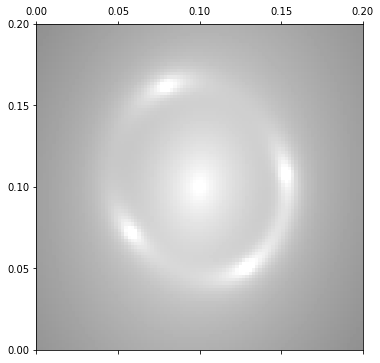


los0 - identical to the image with 0 shear


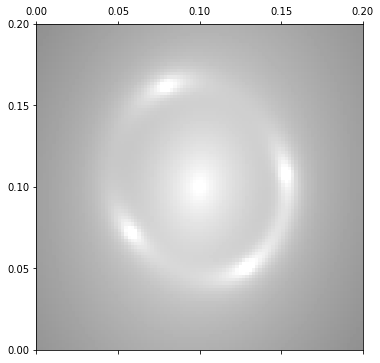


los - line of sight effects clearly visible


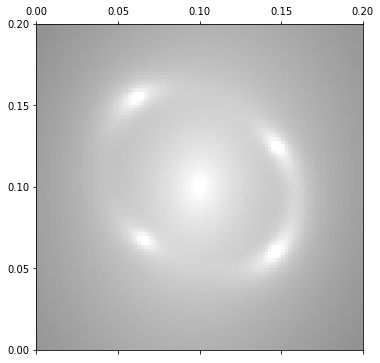

In [10]:
from lenstronomy.ImSim.image_model import ImageModel

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

print('')
print('Shear')

imageModel_shear = ImageModel(data_class_shear, psf_class, lens_model_class_shear, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim_shear = imageModel_shear.image(kwargs_lens_shear, kwargs_source, kwargs_lens_light, kwargs_ps_shear)
kwargs_data['image_data'] = image_sim_shear
data_class_shear.update_data(image_sim_shear)

kwargs_model_shear = {'lens_model_list': lens_model_list_shear, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim_shear), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 0.2, 0, 0.2])
plt.show()

print('')
print('los0 - identical to the image with 0 shear')


imageModel_los0 = ImageModel(data_class_los0, psf_class, lens_model_class_los0, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim_los0 = imageModel_los0.image(kwargs_lens_los0, kwargs_source, kwargs_lens_light, kwargs_ps_los0)
kwargs_data['image_data'] = image_sim_los0
data_class_los0.update_data(image_sim_los0)

kwargs_model_los0 = {'lens_model_list': lens_model_list_los0, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim_los0), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 0.2, 0, 0.2])
plt.show()

print('')
print('los - line of sight effects clearly visible')

imageModel_los = ImageModel(data_class_los, psf_class, lens_model_class_los, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim_los = imageModel_los.image(kwargs_lens_los, kwargs_source, kwargs_lens_light, kwargs_ps_los)
kwargs_data['image_data'] = image_sim_los
data_class_los.update_data(image_sim_los)

kwargs_model_los = {'lens_model_list': lens_model_list_los, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim_los), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 0.2, 0, 0.2])
plt.show()

#import lenstronomy.Util.image_util as image_util

#image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
#poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
#bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
#image_sim = image_sim + bkg + poisson



## Time Delays

time delays are defined in lenstronomy as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. 

There are two quantities relevant for time delays. The first is the Fermat potential in arcsec^2, which is independent of the cosmology. Lens_model will look for either the fermat_potential function of the specific lens model, which usually falls to the single_plane class for single plane lensing, or multi_plane for multi_plane lensing, or alternatively is calculated from the arrival time by dividing this by the time delay distance. If the lens model has neither a fermat potential or an arrival time, lens model will return an error.

### Fermat Potential

The fermat potential can also be calculated using the TDCosmography class. It seems the main difference is that the lens_model calculation takes specific image plane coordinates and returns the fermat potential at that point, while TD cosmography instead takes the point source kwargs as input, and then calculates the fermat potential of each of these point sources. 

tdcosmo.fermat_potential works as follows: 

1. Firstly, it obtains the image positions from the point source class. if the point source class uses 'LENSED_POSITIONS', then the point source class will already have the image positions, and so these are returned. If, however, the source position/s are used, then the point source class will use the model to map this to the image plane.

2. Next, it uses the ray_shooting function from the lens model to trace the positions of these images back to their source. If they don't trace back to the same source, then an error is returned. If, however, they trace back to a point which is sufficiently close, then the source position is taken to be the mean value of these calculated source positions

3. The image positions, source position and lens kwargs are then inputted into the lens model fermat potential, which calculates and returns the fermat potential as normal

**An important note. Usually, the Fermat potential is calculated as a geometric term (related to alpha) minus a potential term. The reason the source position is needed is that alpha is not calculated using the lens model, but instead as the image position minus the source position. In the case of LOS, alpha instead comes from the lens model, as it's the effective displacement angle and a shear matrix which combine to give the geometric term. However, in order for things to work smoothly, I have left the source position inputs in my Fermat potential function, even though they don't go into the calculations at all.**

Now, what I have edited is the Fermat potential in single_plane_los, which is then used by either the lens model or TD Cosmo to obtain the potential. Since all of the relevant calculations make use of the lens model, both classes return the desired Fermat potential.

### Arrival Times

The Fermat Potential is calculated in units of arcsec^2, and requires no knowledge of the redshifts or cosmology. However, these quantities become relevant when calculating the arrival times (once again, relative to a straight line) in units of days.

When this done using lens_model, the arrival_time function will first check if the lens model itself has a function for calculating the arrival time. If it does, then this will be prioritised. If not, the fermat potential will be calculated, and then the code will check if a cosmology has been specified (and return an error if it has not). The arrival time is then calculated by converting the fermat potential from units of arcsec^2 to units of days, using the lensCosmo.time_delay_units function. This function essentially just multiplies the fermat potential by the time delay distance, which depends on the cosmology via the angular diameter distances, and also features the redshift of the lens (see eq. 2.47). 

When this is done using TD Cosmography, this is calculated in exactly the same way - the fermat potential is first calculated (using tdcosmo.fermat_potential), and then the same lensCosmo.time_delay_units function is used to convert this into days.

Since the time delay constant is the same with LOS effects, the arrival time function need not be changed.


## How my function works

I've made edits in two files - lens_model and single_plane_los

### Edits to lens_model

The only edits necessary in the lens_model file was replace "`kwargs_lens`" with "`kwargs`" in the arguments of `fermat_potential` and `arrival_time` (and then in the relevant places within the function). Interestingly, `kwargs` is used everywhere else in the code, defined as

`":param kwargs: list of keyword arguments of lens model parameters matching the lens model classes"`

Then, the `fermat_potential` function took `kwargs_lens` as an argument, rather than `kwargs`. However, within the function, this was defined in exactly the same way as above. The `arrival_time` function similarly took `kwargs_lens` as an argument, rather than `kwargs`, but here, it was defined as 

`":param kwargs_lens: lens model parameter keyword argument list`

However, this is inserted into the `fermat_potential` function within the `arrival_time` function, so I'm almost certain there's no real reason that this was changed.

In my case, since the single_plane_los file relies on the `split_lens_los` function, which splits `kwargs` into `kwargs_lens` and `kwargs_los`, it made sense to update the functions in `lens_model` to consistenly require `kwargs` rather than `kwargs_lens` as an argument

### Edits to single_plane_los

Within the single_plane_los code, I introduced 3 new functions

- **effective_potential**

This takes a lens-plane position $\boldsymbol{\theta}$ as an input, and calculates the effective potential $\psi_{{\rm eff}}$ at this point, according to:

$\psi_{{\rm eff}}(\boldsymbol{\theta}) \equiv \psi_{ods}[(1-\boldsymbol{\Gamma}_{od})\boldsymbol{\theta}]$      (3.14 in Fleury et. al.)

1. The `kwargs` are split according to 

`kwargs_lens, kwargs_los = self.split_lens_los(kwargs)`

2. The angular position where the ray hits the deflector plane, $(1-\boldsymbol{\Gamma}_{od})\boldsymbol{\theta}$, is calculated by inputting x and y into `self.los.distort_vector`, using the "od" parameters

3. The potential of the dominant lens is evaluated at these updated positions x_d and y_d, using 

`effective_potential = super().potential(x_d, y_d, kwargs=kwargs_lens, k=k)`

4. This effective potential is returned


- **effective_alpha**

This takes a lens-plane position $\boldsymbol{\theta}$ as an input, and calculates the effective displacement angle $\boldsymbol{\alpha}_{{\rm eff}}$ at this point, according to:

$\boldsymbol{\alpha}_{{\rm eff}}(\boldsymbol{\theta}) = (\boldsymbol{1} - \boldsymbol{\Gamma}_{od})\boldsymbol{\alpha}_{ods}[(\boldsymbol{1} - \boldsymbol{\Gamma}_{od})\boldsymbol{\theta}]$ (equation 3.15 in Fleury et. al.)

1. The `kwargs` are split according to 

`kwargs_lens, kwargs_los = self.split_lens_los(kwargs)`

2. The angular position where the ray hits the deflector plane, $(1-\boldsymbol{\Gamma}_{od})\boldsymbol{\theta}$, is calculated by inputting x and y into `self.los.distort_vector`, using the "od" parameters

3. The displacement of the dominant lens is evaluated at these updated positions x_d and y_d, using 

`f_x, f_y = super().alpha(x_d, y_d, kwargs=kwargs_lens, k=k)`

4. These values are once again distorted according to the foreground displacement by inputting f_x and f_y into `self.los.distort_vector`, using the "od" parameters

5. The updated f_x and f_y values are returned


- **fermat_potential**

This takes a lens-plane position, and returns the Fermat potential with LOS corrections in the tidal regime, according to

$\phi(\boldsymbol{\theta}) = \frac{1}{2}\boldsymbol{\alpha}_{{\rm eff}}(\boldsymbol{\theta})\cdot(\boldsymbol{1}+\boldsymbol{\Gamma}_{{\rm LOS}}) \boldsymbol{\alpha}_{{\rm eff}}(\boldsymbol{\theta}) - \psi_{{\rm eff}}(\boldsymbol(\theta)$ 

## Comparing Time Delays

In the following, I use both methods for time delays (lens model and td cosmography) to check that my edits to the single_plane_los code are working as they should be. If they are, what I would expect is:

- the shear and los0 datasets will produce identical fermat potentials and time delays
- the los dataset will produce different values to the above, but not enormously so
- for each method, the lens model and td cosmography methods will produce the exact same results

Fortunately, this is exactly what I'm seeing

In [11]:
#Testing time delays
from lenstronomy.Analysis.td_cosmography import TDCosmography

#firstly, using the lens model class

fermat_pot_lens_shear = lens_model_class_shear.fermat_potential(kwargs_ps_shear[0]['ra_image'],kwargs_ps_shear[0]['dec_image'],kwargs_lens_shear)
t_days_lens_shear = lens_model_class_shear.arrival_time(kwargs_ps_shear[0]['ra_image'],kwargs_ps_shear[0]['dec_image'],kwargs_lens_shear,kappa_ext=0)

fermat_pot_lens_los0 = lens_model_class_los0.fermat_potential(kwargs_ps_los0[0]['ra_image'],kwargs_ps_los0[0]['dec_image'],kwargs_lens_los0)
t_days_lens_los0 = lens_model_class_los0.arrival_time(kwargs_ps_los0[0]['ra_image'],kwargs_ps_los0[0]['dec_image'],kwargs_lens_los0,kappa_ext=0)

fermat_pot_lens_los = lens_model_class_los.fermat_potential(kwargs_ps_los[0]['ra_image'],kwargs_ps_los[0]['dec_image'],kwargs_lens_los)
t_days_lens_los = lens_model_class_los.arrival_time(kwargs_ps_los[0]['ra_image'],kwargs_ps_los[0]['dec_image'],kwargs_lens_los,kappa_ext=0)

print('Lens Model Class Time Delays')
print('')
print('Shear Fermat Potential = ', fermat_pot_lens_shear)
print('los0 Fermat Potential = ', fermat_pot_lens_los0)
print('los Fermat Potential = ', fermat_pot_lens_los)
print('')
print('Shear Arrival Time = ', t_days_lens_shear)
print('los0 Arrival Time = ', t_days_lens_los0)
print('los Arrival Time = ', t_days_lens_los)
print('')

#then, using TDCosmography

td_cosmo_shear = TDCosmography(z_lens, z_source, kwargs_model_shear, cosmo_fiducial=cosmo)
t_days_shear = td_cosmo_shear.time_delays(kwargs_lens_shear, kwargs_ps_shear, kappa_ext=0)
fermat_pot_shear = td_cosmo_shear.fermat_potential(kwargs_lens_shear, kwargs_ps_shear)

td_cosmo_los0 = TDCosmography(z_lens, z_source, kwargs_model_los0, cosmo_fiducial=cosmo)
t_days_los0 = td_cosmo_los0.time_delays(kwargs_lens_los0, kwargs_ps_los0, kappa_ext=0)
fermat_pot_los0 = td_cosmo_los0.fermat_potential(kwargs_lens_los0, kwargs_ps_los0)

td_cosmo_los = TDCosmography(z_lens, z_source, kwargs_model_los, cosmo_fiducial=cosmo)
t_days_los = td_cosmo_los.time_delays(kwargs_lens_los, kwargs_ps_los, kappa_ext=0)
fermat_pot_los = td_cosmo_los.fermat_potential(kwargs_lens_los, kwargs_ps_los)

print('')
print('TD Cosmo Time Delays')
print('')
print('Shear Fermat Potential = ', fermat_pot_shear)
print('los0 Fermat Potential = ', fermat_pot_los0)
print('los Fermat Potential = ', fermat_pot_los)
print('')
print('Shear Arrival Time = ', t_days_shear)
print('los0 Arrival Time = ', t_days_los0)
print('los Arrival Time = ', t_days_los)

#Finally, the time delay distance
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

print('')
print('')
print('Time Delay Distance = ', lensCosmo.ddt)

Lens Model Class Time Delays

Shear Fermat Potential =  [-1.20963624 -0.92985101 -0.81604012 -0.71939399]
los0 Fermat Potential =  [-1.20963624 -0.92985101 -0.81604012 -0.71939399]
los Fermat Potential =  [-1.26356202 -1.01392933 -0.82511557 -0.6741933 ]

Shear Arrival Time =  [-5.87291773 -4.51452947 -3.96196504 -3.49273736]
los0 Arrival Time =  [-5.87291773 -4.51452947 -3.96196504 -3.49273736]
los Arrival Time =  [-6.13473335 -4.922739   -4.00602734 -3.27328303]

No line-of-sight effects being added.
No line-of-sight effects being added.
Adding LOS to the main lens.
Adding LOS to the main lens.
Adding LOS to the main lens.
Adding LOS to the main lens.

TD Cosmo Time Delays

Shear Fermat Potential =  [-1.20963624 -0.92985101 -0.81604012 -0.71939399]
los0 Fermat Potential =  [-1.20963624 -0.92985101 -0.81604012 -0.71939399]
los Fermat Potential =  [-1.26356202 -1.01392933 -0.82511557 -0.6741933 ]

Shear Arrival Time =  [-5.87291773 -4.51452947 -3.96196504 -3.49273736]
los0 Arrival Time

### Relative and Measured Time Delays

The actual time delays are not observable, only the relative time delays between images. The convention is to measure these relative to the first image. We then add errors to these measured delays, and these will then be used as part of the fitting as observables.

**They seem to use massive errors for these time delays in the example notebook - for example, a Gaussian sigma value of 10 for a relative time delay of around 1. This seems a bit useless in modelling, and so I've used smaller errors.**

In [12]:
# relative delays (observable). The convention is relative to the first image
dt_days_shear =  t_days_shear[1:] - t_days_shear[0]
dt_days_los0 =  t_days_los0[1:] - t_days_los0[0]
dt_days_los =  t_days_los[1:] - t_days_los[0]

# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [0.2, 0.3, 0.4]  # Gaussian errors

# and here a realisation of the measurement with the quoted error bars
dt_measured_shear = np.random.normal(dt_days_shear, dt_sigma)
dt_measured_los0 = np.random.normal(dt_days_los0, dt_sigma)
dt_measured_los = np.random.normal(dt_days_los, dt_sigma)

print("the measured relative delays with 0 shear are: ", dt_measured_shear)
print('the measured relative delays with los0 are: ', dt_measured_los0)
print('the measured relative delays with los are: ', dt_measured_los)

the measured relative delays with 0 shear are:  [1.25672417 1.84066774 2.08545659]
the measured relative delays with los0 are:  [1.2122999  2.00292541 2.7788136 ]
the measured relative delays with los are:  [1.05041233 2.20053614 2.1848651 ]


##  Setting Up the Modelling

Having (hopefully) successfully implemented the LOS time delays, I now want to examine the modelling of a dataset created with LOS effects. From this point on, I only make use of the los dataset. However, I will use two different methods to attempt to model it. Firstly, a SPEP profile with the usual external shear, and secondly, a los_minimal model.

I include the use of D_dt sampling, which should hopefully mean that the time delay measurements are used to calculate the time delay distance D_dt, which in turn is used to improve the fit.

### Param Stuff

The type of source light model, lens light model and point source model are kept the same as before. To see the things which need to be set here, create_class_instances in class_creator in util can be looked at. Those which are specified here are

- lens_model_list: list of strings indicating the type of lens models
- source_light_model_list: list of strings indicating the types of source light models
- lens_light_model_List: list of strings indicating the types of lens light models
- point_source_model_list: list of strings indicating the point source types
- additional_images_list: what I can find is this. Not sure why it's set to `False`, as opposed to `None` 

`if additional_images_list is not None:
    additional_images_list_i = [additional_images_list[k] for k in index_point_source_model_list[band_index]]`
    
- fixed_magnification_list: this has the exact same thing as abbove for additional_images_list. Setting it to False means that the magnification ratio of point sources isn't fixed to the one given by the lens model, and so the model might arrive at a different ratio. It must be a list of booleans (True vs False) which is the same length as the point_source_type_list

num_source_model is simply the number of light profiles used to model the source, which in this case is 1.

kwargs_constraints are the keyword arguments of the Param() class to handle parameter constraints during the sampling (except upper and lower limits and sampling input mean and width)

- 'joint_source_with_point_source': list [[i_point_source, k_source], [...], ...],
    joint position parameter between lens model and source light model. Not sure exactly how this works
- 'num_point_source_list': the list of number of point sources per point source model class (in this case there's just one point source model class, and there are 4 point sources in this)
- 'solver_type': which solver type to use. The options are 'profile', 'profile_shear', 'ellipse', 'centre' or none'
- 'Ddt_sampling': bool, if True, samples the time-delay distance D_dt (in units of Mpc)

In [13]:
lens_model_list_shear = ['SPEP','SHEAR']
lens_model_list_minimal = ['SPEP','LOS_MINIMAL']


kwargs_model_shear = {'lens_model_list': lens_model_list_shear,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': [False],
                'fixed_magnification_list': [False],  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
                             }

kwargs_model_minimal = {'lens_model_list': lens_model_list_minimal,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': [False],
                'fixed_magnification_list': [False],  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
                             }

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4], 
                      'Ddt_sampling': True,
                              }

### Likelihood stuff

Firstly, we could specify priors for the two shear components, e1 and e2. This might involve assuming that both are zero, and give the standard deviation with which we expect them to be distributed (**is this correct?**). *However, I don't fully understand priors, and it isn't essential for the fit, so I'll omit this bit for now*.

We then set various keyword arguments for the likelihood class.

- check_bounds: bool, option to punish the hard bounds in parameter space (not sure what it means to punish hard bounds in parameter space)
- force_no_add_image: bool, if True: computes ALL image positions of the point source. If there are more images predicted than modelled, a punishment occurs (I think, since this is false, it would be possible for the initial guess to predict more images than the model actually finds, but not really sure)
- source_marg: marginalization addition on the imaging likelihood based on the covariance of the inferred linear coefficients (???)
- image_position_uncertainty: 1-sigma Gaussian uncertainty on the point source position (only used if point_source_likelihood=True). Can't yet find anything about point_source_likelihood, so I'm not sure exactly how that works
- check_matched_source_position: option to check whether point source position solver finds a solution to match all the image positions in the same source plane coordinate
- source_position_tolerance: float, punishment of check_solver occurs when image positions ar epredicted further away than this number
- source_position_sigma: no info given, but the values used for this (and everything else) seems quite standard
- param time_delay_likelihood: bool, if True computes the time-delay likelihood of the FIRST point source

The data, psf and numerics kwargs are put together as image_band, which then is entered into the multi_band_list. Because there is only one band, this list just has one list (image_band) in it.

data_joint is how the data from multiple bands would be joined. the multi_band_type could be either multi-linear or joint-linear. *However, none of this is particularly relevant, because there is only one band?*

In [14]:
#priors omitted here, but look up how they are used

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'time_delay_likelihood': True,
                     }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]

multi_band_list = [image_band]

kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured_los,
                    'time_delays_uncertainties': dt_sigma}

### Sampler stuff

Sampling the likelihood. 

We need initial guesses of the starting parameters, which are deliberately set to differ from the data. 

The parameters which are being searched for in the lens model are the Einstein radius, ellipticities e1 and e2, power law slope of mass profile gamma, and the centre of the profile. The two shear components gamma1 and gamma2 are also guessed.

The parameters which are needed for the source light profile (elliptical sersic), are the R_sersic, n_sersic, the ellipticities and the centre. The same is true for the lens light profile.

Finally, the point source parameters are simply the x and y positions of the point images.

Next, we specify the sigma values for each of the parameters mentioned above, as well as hard upper and lower bounds for the values being searched for.

The only parameters we keep fixed are the coordinates of the external shear, which are chosen to stay at 0 (**is this correct? So the external shear is centred on the origin? Makes sense**)

These parameters are all then combined into kwargs_params, and kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood and kwargs_params are fed into the fitting sequence. 


What I've done here is to come up with two models for the line of sight effects - one with external shear and one with los-minimal

used x_image_los and y_image_los - think this makes sense

In [15]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init_shear = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma1': 0.05, 'gamma2': -0.05}]

kwargs_lens_init_los = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {
    'kappa_od': 0, 'kappa_los': 0,
    'omega_od': 0, 'omega_los': 0,
    'gamma1_od': 0.05, 'gamma2_od': -0.05,
    'gamma1_los': 0.01, 'gamma2_los': -0.1}]


kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image_los+0.01, 'dec_image': y_image_los-0.01}]
kwargs_cosmo_init = {'D_dt': 300}



# initial spread in parameter estimation #
kwargs_lens_sigma_shear = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma1': 0.05, 'gamma2': 0.05}]

kwargs_lens_sigma_los = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {
    'kappa_od': 0, 'kappa_los': 0,
    'omega_od': 0, 'omega_los': 0,
    'gamma1_od': 0.01, 'gamma2_od': 0.01,
    'gamma1_los': 0.01, 'gamma2_los': 0.01}]


kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]
kwargs_cosmo_sigma = {'D_dt': 500}




# hard bound lower limit in parameter space #
kwargs_lower_lens_shear = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma1': -0.5, 'gamma2': -0.5}]

kwargs_lower_lens_los = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {
    'kappa_od': -0.1, 'kappa_los': -0.1,
    'omega_od': -0.1, 'omega_los': -0.1,
    'gamma1_od': -0.2, 'gamma2_od': -0.2,
    'gamma1_los': -0.2, 'gamma2_los': -0.2}]



kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image_los), 'dec_image': -10 * np.ones_like(y_image_los)}]
kwargs_lower_cosmo = {'D_dt': 0}




# hard bound upper limit in parameter space #
kwargs_upper_lens_shear = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma1': 0.5, 'gamma2': 0.5}]

kwargs_upper_lens_los = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {
    'kappa_od': 0.1, 'kappa_los': 0.1,
    'omega_od': 0.1, 'omega_los': 0.1,
    'gamma1_od': 0.2, 'gamma2_od': 0.2,
    'gamma1_los': 0.2, 'gamma2_los': 0.2}]



kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image_los), 'dec_image': 10 * np.ones_like(y_image_los)}]
kwargs_upper_cosmo = {'D_dt': 10000}



# keeping parameters fixed
kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
kwargs_source_fixed = [{}]
kwargs_lens_light_fixed = [{}]
kwargs_ps_fixed = [{}]
kwargs_cosmo_fixed = [{}]

lens_params_shear = [kwargs_lens_init_shear, kwargs_lens_sigma_shear, kwargs_lens_fixed, kwargs_lower_lens_shear, kwargs_upper_lens_shear]
lens_params_los = [kwargs_lens_init_los, kwargs_lens_sigma_los, kwargs_lens_fixed, kwargs_lower_lens_los, kwargs_upper_lens_los]

source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, kwargs_cosmo_fixed, kwargs_lower_cosmo, kwargs_upper_cosmo]

kwargs_params_shear = {'lens_model': lens_params_shear,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}

kwargs_params_los = {'lens_model': lens_params_los,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}

## The Fitting 

We put all of the keyword argument lists from previously into the fitting sequence. The fitting sequence class with the function fit_sequence called takes a list of keyword arguments as an input, a separate list for each of the fitting routines used, and returns the fitting results. Here, both the PSO (particle swarm optimisation) and MCMC routines are used.

I think when best_fit is called, this gives the most accurate fitting result. In this case, it seems to match up with the MCMC run, but I presume it will choose whichever of the two has the smallest deviation from the data


In [16]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

fitting_seq_shear = FittingSequence(kwargs_data_joint, kwargs_model_shear, kwargs_constraints, kwargs_likelihood, kwargs_params_shear)
fitting_seq_los = FittingSequence(kwargs_data_joint, kwargs_model_minimal, kwargs_constraints, kwargs_likelihood, kwargs_params_los)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 300, 'n_iterations': 300}],
        ['MCMC', {'n_burn': 800, 'n_run': 800, 'walkerRatio': 25, 'sigma_scale': .1}]
]

#fitting_kwargs_list = [
#        ['PSO', {'sigma_scale': .1, 'n_particles': 300, 'n_iterations': 300}]
#]


chain_list_shear = fitting_seq_shear.fit_sequence(fitting_kwargs_list)
chain_list_los = fitting_seq_los.fit_sequence(fitting_kwargs_list)

kwargs_result_shear = fitting_seq_shear.best_fit()
kwargs_result_los = fitting_seq_los.best_fit()

No line-of-sight effects being added.
No line-of-sight effects being added.
No line-of-sight effects being added.
No line-of-sight effects being added.
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
Max iteration reached! Stopping.
-0.12894836594832315 reduced X^2 of best position
-642.8076042523909 logL
9970 effective number of data points
[{'theta_E': 1.401621315015692, 'gamma': 1.9822733883480528, 'e1': 0.05996483709538957, 'e2': 0.06277541089174249, 'center_x': 0.007016896144618159, 'center_y': 0.0013183025919990897}, {'gamma1': 0.07862432173721637, 'gamma2': -0.05907295169017773, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10129733277548811, 'n_sersic': 2.9912286932904695, 'e1': -0.12103949607181598, 'e2': 0.0021123079939097435, 'center_x': 0.004786398972190797, 'center_y': 0.10534985542437167}] source result
[{'amp': 1, 'R_sersic': 1.0006927158106789, 'n_sersic': 1.999149811411

100%|████████████████████████████████████████████████████████████████████████████| 1600/1600 [2:18:40<00:00,  5.20s/it]


Computing the MCMC...
Number of walkers =  675
Burn-in iterations:  800
Sampling iterations (in current run): 1600
8325.877096414566 time taken for MCMC sampling
No line-of-sight effects being added.
Adding LOS_MINIMAL to the main lens.
Adding LOS_MINIMAL to the main lens.
Adding LOS_MINIMAL to the main lens.
Adding LOS_MINIMAL to the main lens.
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
Max iteration reached! Stopping.
-0.671714951134225 reduced X^2 of best position
-3346.4838865507086 logL
9964 effective number of data points
[{'theta_E': 1.361907499237925, 'gamma': 1.8475914738882124, 'e1': 0.05079966215027451, 'e2': 0.07452909750165154, 'center_x': 0.00398222712707536, 'center_y': -0.0020640647184562502}, {'kappa_od': 0.0, 'gamma1_od': 0.013197361807295842, 'gamma2_od': -0.0031481718636546872, 'omega_od': 0.0, 'kappa_los': 0.0, 'gamma1_los': 0.09014632679412692, 'gamma2_los': -0.02342381461442

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

## Plotting and Comparing Results

### Fitting Plots

Here, we can plot all of our results

Firstly, we define the ModelPlot class, which takes multi_band_list (recall `image_band = [kwargs_data, kwargs_psf, kwargs_numerics], multi_band_list = [image_band]`), the model kwargs, the result kwargs (which consists of the result of the best fit), and a specification of the arrow size and the color of the plots (`gist_heat` in this case). When this is defined, if n_data is greater than 0, the reduced X^2 of all evaluated imaging data combined is printed. This is calculated as 

reduced X^2 = logL * 2/ n_data

n_data is the number of independent data points in the combined fitting

L is the likelihood - the closer it is to 1, the more likely this combination of parameters accurately describes the data. Thus we would expect -logL to decrease with successive iterations, if these iterations are converging on the correct solution, and this is indeed what we observe.

Generally, you want a reduced chi-squared value as close to 1 as possible.

We then print the list of parameters which are fitted.

The `chain_plot.plot_chain_list(chain_list, i)` plots the 4 white-background graphs. Try to understand some of this better. 

This is all for the particle swarm optimisation - iteratively varying the parameters towards their optimum values

The first graph plots -logL as a function of the number of iterations. We see that its value decreases with successive iterations, meaning that the parameters are more and more likely to accurately describe the data.

The second plots the particle position - presumably, this is the distance of the parameter value away from its final value?

The third is the particle velocity - the amount by which the parameter changes per iteration?

No idea about the fourth

My confusion - I would imagine the particle position tells you how poor your initial guesses were, but when I make the worst one better, the fit gets worse 


No line-of-sight effects being added.
No line-of-sight effects being added.
Adding LOS_MINIMAL to the main lens.
Adding LOS_MINIMAL to the main lens.
Shear Fit


No line-of-sight effects being added.
-0.08585477092039129 reduced X^2 of all evaluated imaging data combined.
No line-of-sight effects being added.
reduced chi^2 of data  0 =  0.08585477092039134
No line-of-sight effects being added.
(27, ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt'])


LOS Fit


Adding LOS_MINIMAL to the main lens.
-0.19112993409269816 reduced X^2 of all evaluated imaging data combined.
Adding LOS_MINIMAL

NameError: name 'chain_list_los' is not defined

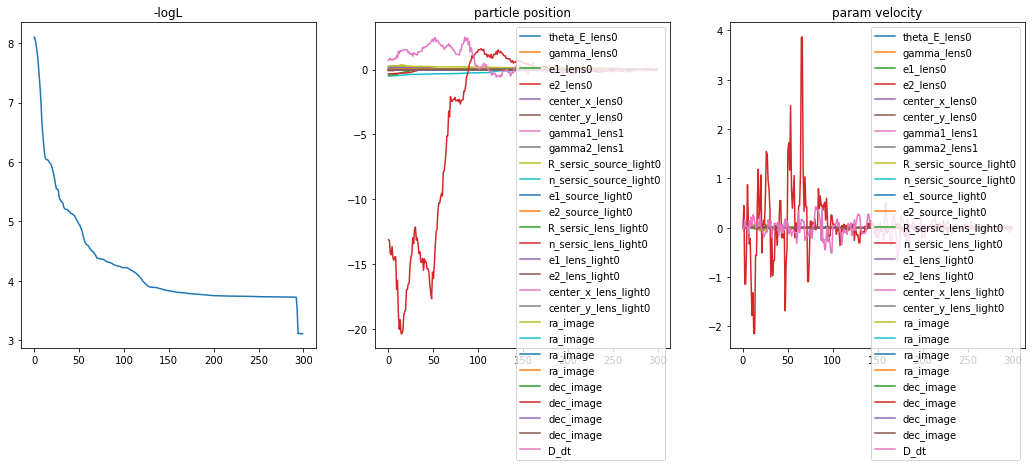

<Figure size 432x288 with 0 Axes>

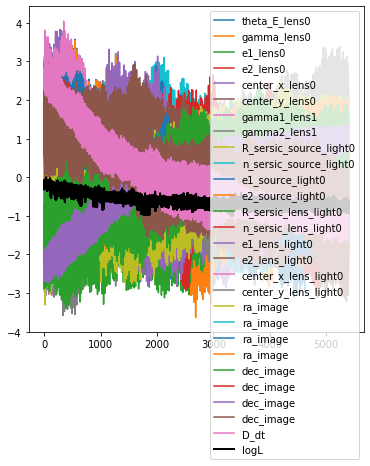

In [17]:
kwargs_result_shear = fitting_seq_shear.best_fit()
kwargs_result_los = fitting_seq_los.best_fit()

from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

print('Shear Fit')
print('')
print('')

modelPlot_shear = ModelPlot(multi_band_list, kwargs_model_shear, kwargs_result_shear, arrow_size=0.02, cmap_string="gist_heat")

param_class_shear = fitting_seq_shear.param_class
print(param_class_shear.num_param())
#print(chain_list)

for i in range(len(chain_list_shear)):
    chain_plot.plot_chain_list(chain_list_shear, i)

print('')
print('')
print('LOS Fit')
print('')
print('')

modelPlot_los = ModelPlot(multi_band_list, kwargs_model_minimal, kwargs_result_los, arrow_size=0.02, cmap_string="gist_heat")

param_class_los = fitting_seq_los.param_class
print(param_class_los.num_param())
#print(chain_list)

for i in range(len(chain_list_los)):
    chain_plot.plot_chain_list(chain_list_los, i)

### Image Plots

We now plot images to represent the data and the fit. Firstly, we plot the data, and next to it the reconstructed from the model. 

On the top right are the normalised residuals. We want this to be as random as possible - an overly strong presence of blue or red, or any structure apparent in the residuals, would indicate problems with the fit.

On the next line, on the left, is a reconstruction of the source from the modelling. The quasar position is indicated with a star.

The next plot is the convergence - i.e., the projected surface mass density of the lens. Note: this is a plot of the mass distribution, not the light, as seen in the data frame.

Next is the magnification, which shows the lensing magnification in the field of view of the data frame

The next line of plots separate out the light from the lens and from the source (as modelled), and then combine them into the reconstructed image.

Recap the difference between convolved and unconvolved


Shear Fit, LOS Fit




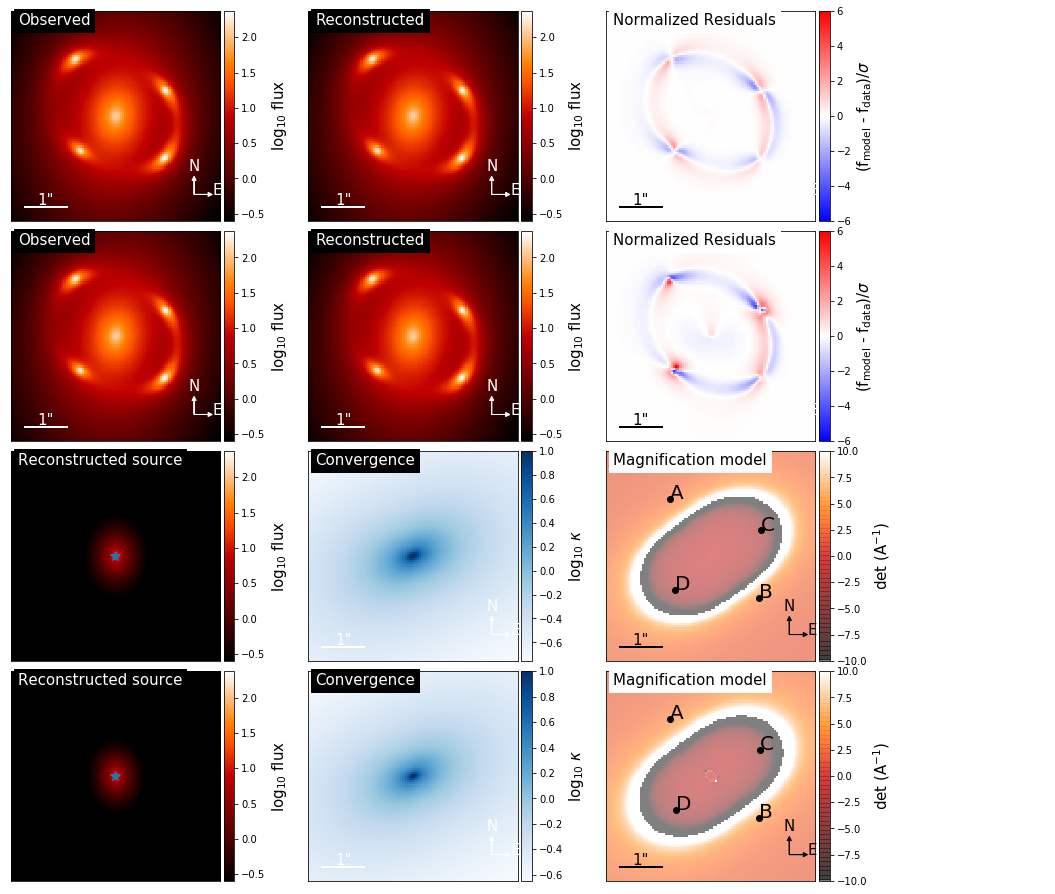

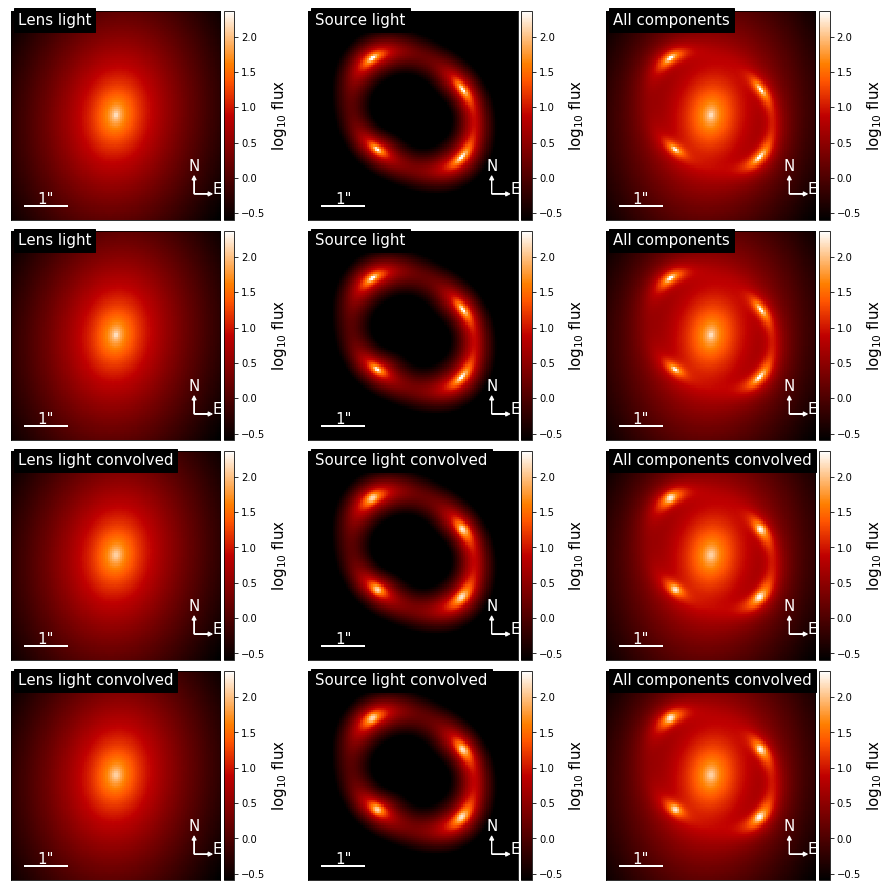

kwargs_shear =  {'kwargs_lens': [{'theta_E': 1.3985733757898093, 'gamma': 1.971144088190635, 'e1': 0.06011560475187007, 'e2': 0.06153109312931001, 'center_x': 0.007151494592154243, 'center_y': 0.0025148166371368385}, {'gamma1': 0.07938136889346516, 'gamma2': -0.05823432669487147, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 7963.902688772147, 'R_sersic': 0.10101938917550078, 'n_sersic': 3.047580464012706, 'e1': -0.1216462042229783, 'e2': 0.0022125265039079673, 'center_x': 0.004469624590926619, 'center_y': 0.10457162216873456}], 'kwargs_lens_light': [{'amp': 3010.529604235, 'R_sersic': 0.9977796729336208, 'n_sersic': 1.9972435131765816, 'e1': -0.15035712719726596, 'e2': 0.04037724999722332, 'center_x': 0.0001798011734125457, 'center_y': -0.0001756700357717074}], 'kwargs_ps': [{'ra_image': array([-0.9635359 ,  1.16189845,  1.18909228, -0.84509435]), 'dec_image': array([ 1.35570755, -1.00275684,  0.61017067, -0.81556371]), 'point_amp': array([306.75571704, 384.56681038, 296.71257938

In [18]:
print('')
print('Shear Fit, LOS Fit')
print('')
print('')

f, axes = plt.subplots(4, 3, figsize=(16, 16), sharex=False, sharey=False)

modelPlot_shear.data_plot(ax=axes[0,0])
modelPlot_shear.model_plot(ax=axes[0,1])
modelPlot_shear.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)

modelPlot_los.data_plot(ax=axes[1,0])
modelPlot_los.model_plot(ax=axes[1,1])
modelPlot_los.normalized_residual_plot(ax=axes[1,2], v_min=-6, v_max=6)

modelPlot_shear.source_plot(ax=axes[2, 0], deltaPix_source=0.01, numPix=100)
modelPlot_shear.convergence_plot(ax=axes[2, 1], v_max=1,cmap='Blues')
modelPlot_shear.magnification_plot(ax=axes[2, 2])

modelPlot_los.source_plot(ax=axes[3, 0], deltaPix_source=0.01, numPix=100)
modelPlot_los.convergence_plot(ax=axes[3, 1], v_max=1,cmap='Blues')
modelPlot_los.magnification_plot(ax=axes[3, 2])

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(4, 3, figsize=(16, 16), sharex=False, sharey=False)

modelPlot_shear.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot_shear.decomposition_plot(ax=axes[2,0], text='Lens light convolved', lens_light_add=True)
modelPlot_shear.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)

modelPlot_los.decomposition_plot(ax=axes[1,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot_los.decomposition_plot(ax=axes[3,0], text='Lens light convolved', lens_light_add=True)
modelPlot_los.decomposition_plot(ax=axes[1,1], text='Source light', source_add=True, unconvolved=True)

modelPlot_shear.decomposition_plot(ax=axes[2,1], text='Source light convolved', source_add=True)
modelPlot_shear.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot_shear.decomposition_plot(ax=axes[2,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

modelPlot_los.decomposition_plot(ax=axes[3,1], text='Source light convolved', source_add=True)
modelPlot_los.decomposition_plot(ax=axes[1,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot_los.decomposition_plot(ax=axes[3,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


print('kwargs_shear = ', kwargs_result_shear)
print('')
print('')
print('kwargs_los = ', kwargs_result_los)


## Plotting MCMC Posteriors

### 'Raw' Posteriors

As I understand it, these plots show how likely a parameter is to take on a certain value, given a different value of another parameter. Then the plots at the end are the 1D posteriors - simply how likely a parameter is to have a certain value

number of non-linear parameters in the MCMC process:  27
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  540000


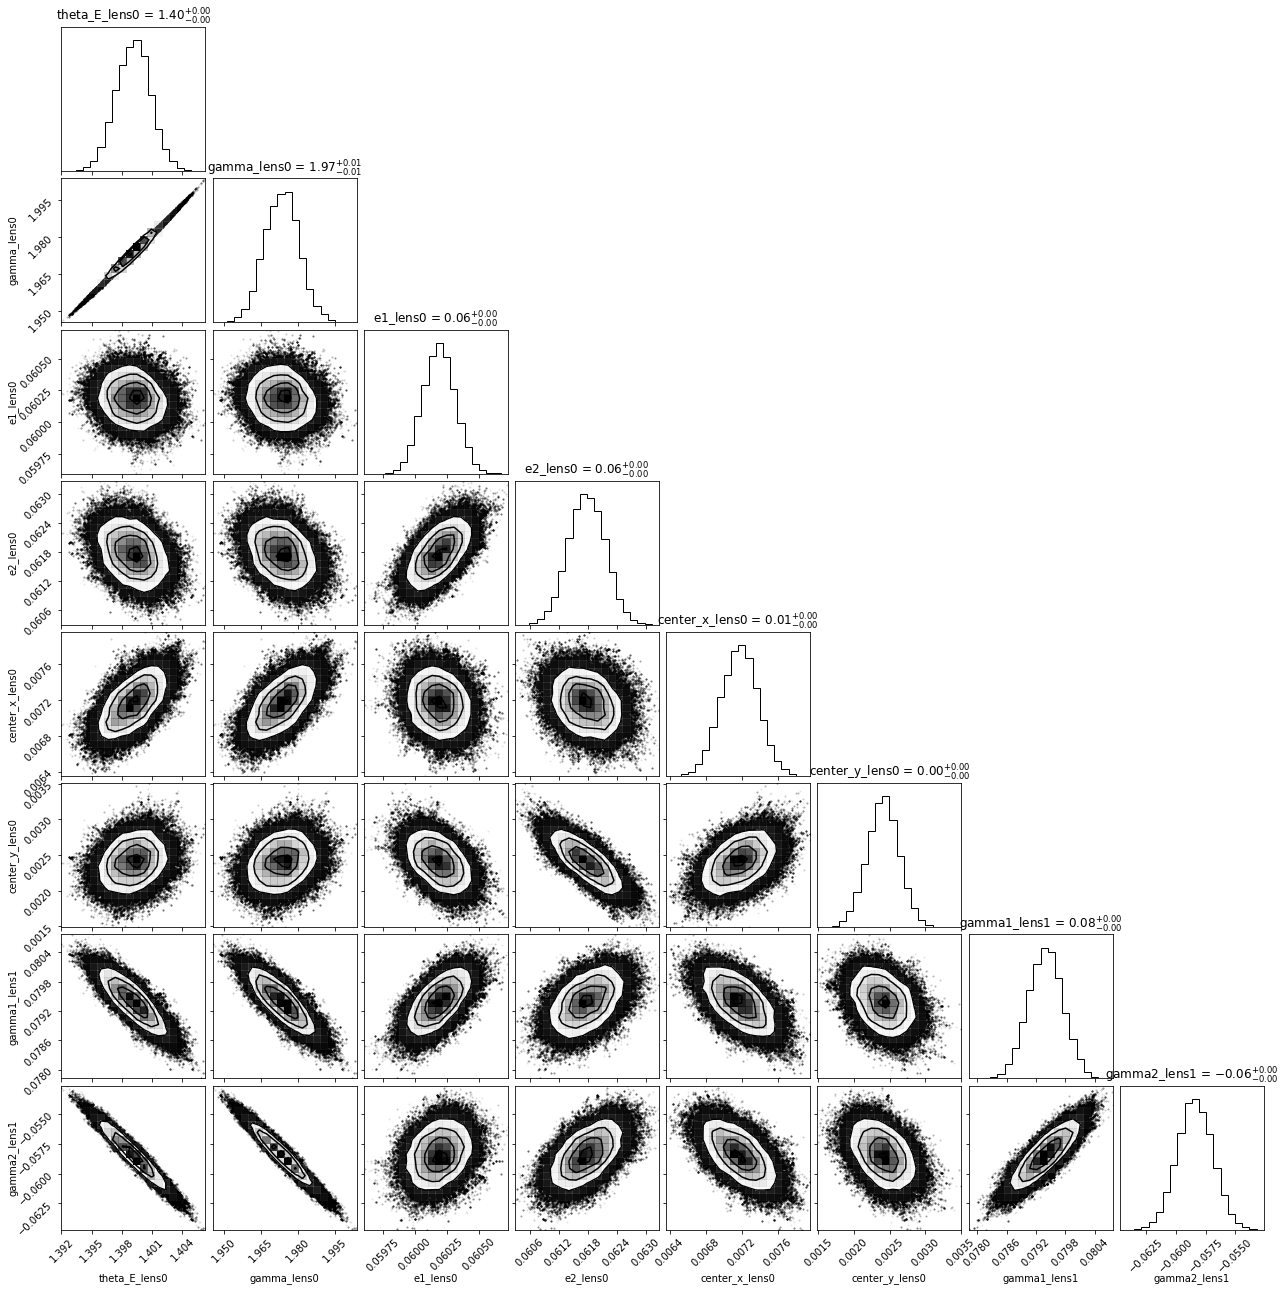

In [30]:
# here we plot the 'raw' MCMC posteriors

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list_shear[1]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
#plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)

No line-of-sight effects being added.


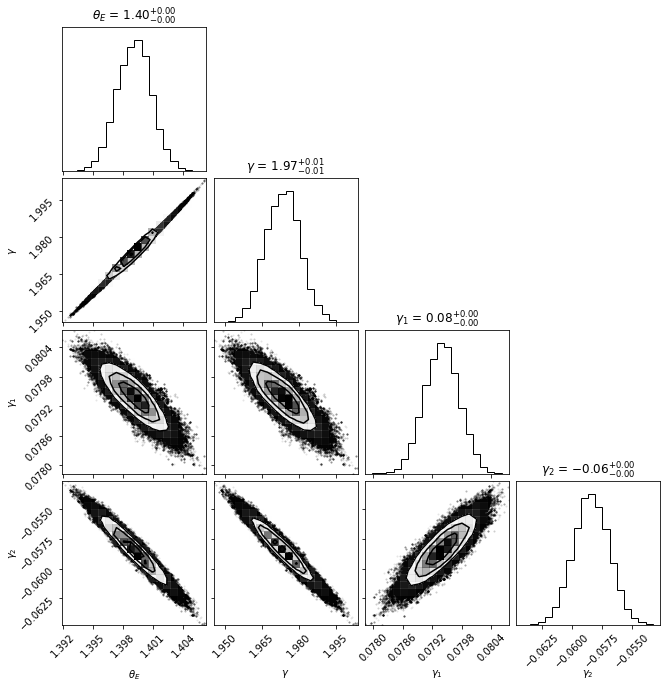

In [31]:
# here we plot a subset of the 'processed' MCMC posteriors

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model_shear, kwargs_lens_fixed, kwargs_source_fixed, kwargs_lens_light_fixed, kwargs_ps_fixed, 
              kwargs_lens_init=kwargs_result_shear['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result_shear = param.args2kwargs(samples_mcmc[i])
    theta_E = kwargs_result_shear['kwargs_lens'][0]['theta_E']
    gamma = kwargs_result_shear['kwargs_lens'][0]['gamma']
    gamma1, gamma2 = kwargs_result_shear['kwargs_lens'][1]['gamma1'], kwargs_result_shear['kwargs_lens'][1]['gamma2']
    mcmc_new_list.append([theta_E, gamma, gamma1, gamma2])


plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)

In [34]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)

173.39369148433522
